<a href="https://colab.research.google.com/github/EzraMW/ML/blob/main/Transfer_Learning_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
import re
from matplotlib import pyplot
from matplotlib.image import imread

In [54]:
!unzip /content/dataset2.zip -d /content/dataset2

Archive:  /content/dataset2.zip
replace /content/dataset2/dataset2/cloudy1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


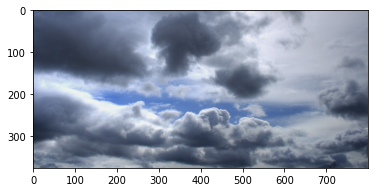

In [55]:
image = imread('/content/dataset2/dataset2/cloudy102.jpg')
pyplot.imshow(image)

In [56]:
image.shape

(377, 800, 3)

In [57]:
directory_path = '/content/dataset2/dataset2'

# Process the Data

Convert each image into numpy arrays to pass into the model and label them all with the correct categorical label

In [58]:
# Initialize an empty numpy array for your images
X = []

# Initialize an empty list for your labels
y = []

# Define a dictionary to map category strings to integer labels
category_to_label = {'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    # Check if the file is an image
    if filename.endswith('.jpg'):
        # Extract the category string from the filename
        category = filename.split('.')[0].split(' ')[0].lower()
        # print(category)
        category = re.sub(r'\d+', '', category)
        # Check if the category string exists in the filename
        if category in category_to_label:
            # Load the image using OpenCV
            image = imread(os.path.join(directory_path, filename))
            
            if image is None:
              print("Error: could not read file {}".format(filename))
              break
            # Verify that image size is valid
            if image.shape[0] == 0 or image.shape[1] == 0:
              print("Error: image size is empty for file {}".format(filename))
              break

            image = cv2.resize(image, (150, 150))
            
            # if its graycale, convert to color
            if image.shape == (150, 150):
              image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
              
            # if image has alpha channel, remove it
            if image.shape == (150, 150, 4):
              image = image[:, :, :3]
            X.append(image)
            # Append the label to the y list
            y.append(category_to_label[category])

One hot encode targets

In [59]:
y = np.array(y)
print(y)
enc = OneHotEncoder()
y_oneHot = enc.fit_transform(y.reshape(-1,1)).toarray()
y_oneHot

[2 0 2 ... 1 1 1]


array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

Let's see the shape of the data

In [60]:
print(len(X), len(X[0]), len(X[34][25]), len(X[35][75][28]))

1122 150 150 3


In [61]:
X_np = np.array(X)

In [62]:
X_np.shape

(1122, 150, 150, 3)

In [63]:
X_rescaled = X_np /255.0

train test split

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rescaled, y_oneHot, test_size=0.2, random_state=42)

# Regular CovNet Model

In [65]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [66]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(4, activation='softmax'))

In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
history = model.fit(X_train, y_train, epochs =20, batch_size=32, validation_split=.2)

Epoch 1/20
23/23 [==============================] - 3s 41ms/step - loss: 0.8876 - accuracy: 0.6053 - val_loss: 0.7378 - val_accuracy: 0.6778
Epoch 2/20
23/23 [==============================] - 1s 33ms/step - loss: 0.6099 - accuracy: 0.7406 - val_loss: 0.6270 - val_accuracy: 0.8056
Epoch 3/20
23/23 [==============================] - 1s 29ms/step - loss: 0.4439 - accuracy: 0.8354 - val_loss: 0.7338 - val_accuracy: 0.8056
Epoch 4/20
23/23 [==============================] - 1s 30ms/step - loss: 0.3815 - accuracy: 0.8563 - val_loss: 0.4771 - val_accuracy: 0.8944
Epoch 5/20
23/23 [==============================] - 1s 30ms/step - loss: 0.3461 - accuracy: 0.8591 - val_loss: 0.3946 - val_accuracy: 0.9111
Epoch 6/20
23/23 [==============================] - 1s 30ms/step - loss: 0.2947 - accuracy: 0.8801 - val_loss: 0.4879 - val_accuracy: 0.8778
Epoch 7/20
23/23 [==============================] - 1s 37ms/step - loss: 0.2892 - accuracy: 0.8787 - val_loss: 0.5934 - val_accuracy: 0.8500
Epoch 8/20
23

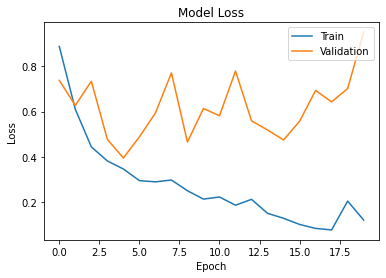

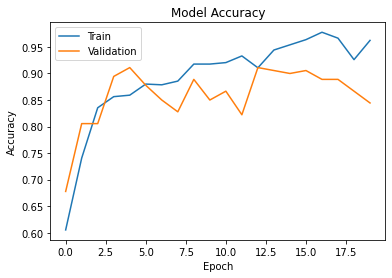

In [69]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Now let's add some dropout to the model to prevent some of the overfitting

In [70]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
history = model.fit(X_train, y_train, epochs =10, batch_size=32, validation_split=.2)

Epoch 1/10
23/23 [==============================] - 4s 55ms/step - loss: 1.0948 - accuracy: 0.4756 - val_loss: 1.3720 - val_accuracy: 0.3944
Epoch 2/10
23/23 [==============================] - 1s 39ms/step - loss: 0.9327 - accuracy: 0.5760 - val_loss: 0.8577 - val_accuracy: 0.6556
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.6789 - accuracy: 0.7266 - val_loss: 0.7182 - val_accuracy: 0.7500
Epoch 4/10
23/23 [==============================] - 1s 39ms/step - loss: 0.5291 - accuracy: 0.7810 - val_loss: 0.6896 - val_accuracy: 0.7889
Epoch 5/10
23/23 [==============================] - 1s 40ms/step - loss: 0.4722 - accuracy: 0.8187 - val_loss: 0.5938 - val_accuracy: 0.8389
Epoch 6/10
23/23 [==============================] - 1s 39ms/step - loss: 0.4164 - accuracy: 0.8410 - val_loss: 0.5536 - val_accuracy: 0.8722
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - loss: 0.3883 - accuracy: 0.8591 - val_loss: 0.5753 - val_accuracy: 0.9000
Epoch 8/10
23

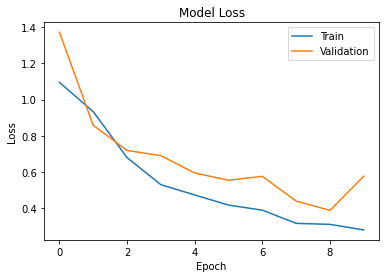

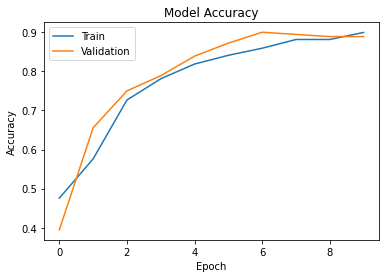

In [72]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The training accuracy clearly lessened from the dropouts but the curves are much smoother as we have prevented overfitting

# Transfer Learning Model

In [78]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, input_shape=(150, 150, 3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
drop = Dropout(.5)(class1)
output = Dense(4, activation='softmax')(drop)
# define new model
model = Model(inputs=model.inputs, outputs=output)

In [79]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs =10, batch_size=32, validation_split=.2)

Epoch 1/10
23/23 [==============================] - 4s 110ms/step - loss: 0.9683 - accuracy: 0.6416 - val_loss: 0.5152 - val_accuracy: 0.7889
Epoch 2/10
23/23 [==============================] - 2s 101ms/step - loss: 0.4089 - accuracy: 0.8633 - val_loss: 0.3022 - val_accuracy: 0.9056
Epoch 3/10
23/23 [==============================] - 2s 87ms/step - loss: 0.2733 - accuracy: 0.9107 - val_loss: 0.2413 - val_accuracy: 0.8944
Epoch 4/10
23/23 [==============================] - 2s 86ms/step - loss: 0.2000 - accuracy: 0.9233 - val_loss: 0.2439 - val_accuracy: 0.8778
Epoch 5/10
23/23 [==============================] - 2s 97ms/step - loss: 0.1569 - accuracy: 0.9623 - val_loss: 0.1614 - val_accuracy: 0.9389
Epoch 6/10
23/23 [==============================] - 2s 87ms/step - loss: 0.1066 - accuracy: 0.9637 - val_loss: 0.1738 - val_accuracy: 0.9278
Epoch 7/10
23/23 [==============================] - 2s 99ms/step - loss: 0.0975 - accuracy: 0.9819 - val_loss: 0.1818 - val_accuracy: 0.9111
Epoch 8/10


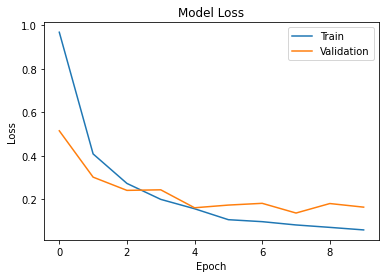

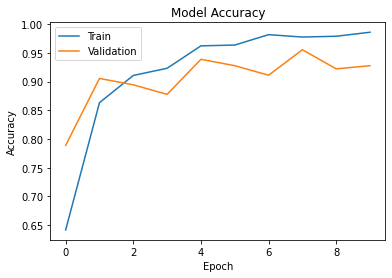

In [80]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Using transfer learning from the keras VGG16 model we were able to achieve > 99% accuracy on the training data and ~ 94% accuracy on the validation data, even while using dropout to smoothen out the curves and lessen the amount of overfitting